In [1]:
import pandas as pd
import numpy as np

import shap

import os
import sys
import collections
import torch
import matplotlib.pyplot as plt
import pickle as pkl

from scipy import stats
from shapreg import shapley, games, removal, shapley_sampling
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from utilities import *
from dataset import Dataset

from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)

module_path = os.path.abspath(os.path.join('CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models as cate_models
import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
def plot_categorical_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]
    
    agg_shap = []
    agg_x_test = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_instance = [np.argmax(l) if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test.append(agg_x_test_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test = np.array(agg_x_test)

    # Determine the indices of categorical features
    categorical_indices = [i for i, n in enumerate(n_categories) if n > 1]
    
    for cat_index in categorical_indices:
        # Plot SHAP values for each category
        unique_categories = np.unique(agg_x_test[:, cat_index])
        for cat in unique_categories:
            shap_values_cat = agg_shap[agg_x_test[:, cat_index] == cat, cat_index]
            plt.scatter([cat]*len(shap_values_cat), shap_values_cat,s=4, label=f'Category {cat}')

        plt.title(f"Feature: {feature_names[cat_index]}")
        plt.xlabel("Category")
        plt.ylabel("SHAP Value")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()



def plot_feature_values(feature_values, x_test, n_categories):

    split_indices = np.cumsum(n_categories)[:-1]  # Determine split indices based on n_categories
    
    agg_shap = []
    agg_x_test_colors = []

    # Process each feature values and test instance
    for feature_val, test_instance in zip(feature_values, x_test):
        
        feature_val_split = np.split(feature_val, split_indices)
        test_instance_split = np.split(test_instance, split_indices)
        
        # Sum SHAP values for each category and keep original feature values for color representation
        agg_shap_instance = [np.sum(l) for l in feature_val_split]
        agg_x_test_colors_instance = [l[np.argmax(l)] if n > 1 else l[0] for l, n in zip(test_instance_split, n_categories)]
        
        agg_shap.append(agg_shap_instance)
        agg_x_test_colors.append(agg_x_test_colors_instance)

    # Convert lists to numpy arrays
    agg_shap = np.array(agg_shap)
    agg_x_test_colors = np.array(agg_x_test_colors)

    # Determine the indices of the features with highest mean absolute SHAP values
    ind = np.argpartition(np.abs(agg_shap).mean(0), -len(n_categories))[-len(n_categories):]
    
    # Create the feature names with associated mean absolute SHAP values
    ranked_feature_names = [f"{a}: {b:.3f}" for a, b in zip(feature_names[ind], np.abs(agg_shap[:, ind]).mean(0))]

    # Plot the summary
    shap.summary_plot(
        agg_shap[:, ind],
      agg_x_test_colors[:, ind], 
      feature_names=ranked_feature_names,
      show=False
    )

    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('IST3 - Shapley Value: Female Baseline', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "rt-TPA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "rt-TPA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)


def plot_feature_values_original(feature_values, x_test, feature_names):

    feature_num = feature_values.shape[1]
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(3), -feature_num)[-feature_num:]

    
    ranked_feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(feature_names)[ind], np.abs(feature_values[:, ind]).mean(0).round(3))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=ranked_feature_names,
        title = "IG",
        show=False
     )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('IST3 - Shapley Value ', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.1, -2.5, "rt-TPA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.1, -2.5, "rt-TPA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)


def plot_feature_values_ind(feature_values, x_test, indices):
    
    
    feature_values = feature_values[:, indices]
    x_test = x_test[:, indices]
    names = feature_names_v2[indices]
    print(names)


    names = [stroketype_mapping.get(i) for i in names]

    feature_num = feature_values.shape[1]
    
    ind = np.argpartition(np.abs(feature_values).mean(0).round(4), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(names)[ind], np.abs(feature_values[:, ind]).mean(0).round(2))
    ]
    
    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        title = "IG",
        show=False
     )
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('IST3 - Stroketype', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.4, -2.5, "rt-TPA worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.4, -2.5, "rt-TPA better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)
    

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

Index(['stroketype_1.0', 'stroketype_2.0', 'stroketype_3.0', 'stroketype_4.0',
       'stroketype_5.0'],
      dtype='object')


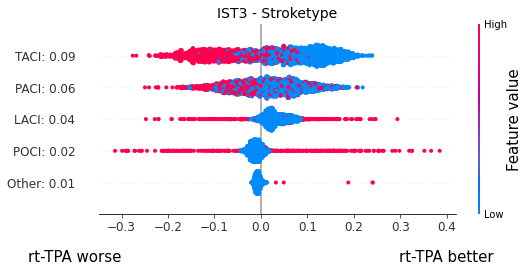

In [114]:
plot_feature_values_ind(baseline_shapley_value, baseline, [13, 14, 15, 16,17])

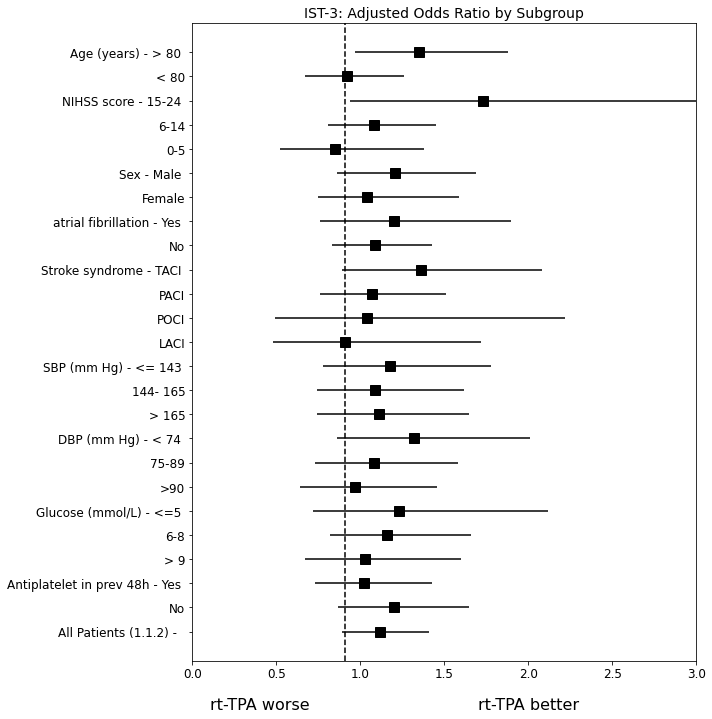

In [440]:
import matplotlib.pyplot as plt

# Data
data = [
    ["", 1.12, 0.89, 1.41,"All Patients (1.1.2)"],

    ["No", 1.20, 0.87,1.65, "Antiplatelet in prev 48h"],
    ["Yes",1.02, 0.73,1.43, "Antiplatelet in prev 48h"],

    ['> 9', 1.03, 0.67, 1.60,"Glucose (mmol/L)"],
     ['6-8', 1.16, 0.82, 1.66,"Glucose (mmol/L)"],
     ['<=5', 1.23, 0.72, 2.12,"Glucose (mmol/L)"],

     ['>90', 0.97, 0.64, 1.46,"DBP (mm Hg)"],
     ['75-89', 1.08, 0.73, 1.58,"DBP (mm Hg)"],
      ['< 74', 1.32, 0.86, 2.01,"DBP (mm Hg)"],

      ['> 165', 1.11, 0.74, 1.65,"SBP (mm Hg)"],
     ['144- 165', 1.09, 0.74, 1.62,"SBP (mm Hg)"],
     ['<= 143', 1.18, 0.78, 1.78,"SBP (mm Hg)"],
    
      ['LACI', 0.91, 0.48, 1.72,"Stroke syndrome"],
      ['POCI', 1.04, 0.49, 2.22,"Stroke syndrome"],
      ['PACI', 1.07, 0.76, 1.51,"Stroke syndrome"],
      ['TACI', 1.36, 0.89, 2.08,"Stroke syndrome"],
    
     ['No', 1.09, 0.83, 1.43,"atrial fibrillation"],
     ['Yes', 1.20, 0.76, 1.90,"atrial fibrillation"],

     ['Female', 1.04, 0.75, 1.59,"Sex"],
     ['Male',1.21, 0.86, 1.69, "Sex"],

     ['0-5', 0.85, 0.52, 1.38, 'NIHSS score'],
     ['6-14', 1.08, 0.81, 1.45, 'NIHSS score'],
     ['15-24',1.73, 0.94, 3.20, 'NIHSS score'],
     # ['>25',7.43, 0.43, 12.9, 'NIHSS score'],
    
     # ['>= 25',7.43, 0.43, 12.9, 'NIHSS'],
    
     ["< 80",0.92, 0.67, 1.26 , "Age (years)"],
     ["> 80", 1.35, 0.97, 1.88 , "Age (years)"]
]

labels, medians, mins, maxs, categories = zip(*data)

# Compute the errors

lower_err = [median - min_ for median, min_ in zip(medians, mins)]
upper_err = [max_ - median for max_, median in zip(maxs, medians)]
errors = [lower_err, upper_err]

fig, ax = plt.subplots(figsize=(10,10))

# Plotting
y_range = range(len(labels))

# Reversing order
y_range = y_range[::-1]
medians = medians[::-1]
errors = [errors[0][::-1], errors[1][::-1]]

plt.errorbar(medians, y_range, xerr=errors, fmt='s', color="black", markersize=10)

# Set labels with category after range
new_labels = []
last_category = None
for label, min_, max_, category in reversed(list(zip(labels, mins, maxs, categories))):
    if category != last_category:
        new_labels.append(f'{category} - {label} ')
        last_category = category
    else:
        new_labels.append(f'{label}')

ax.set_yticks(y_range)
ax.set_yticklabels(new_labels, fontsize=12) # Larger font size here

ax.tick_params(axis='x', labelsize=12) # Larger font size for x-axis ticks

# Add custom text to the x-axis
ax.text(0.4, -3.2, "rt-TPA worse", color="black", ha="center", fontsize=16) # Larger font size here
ax.text(2.0, -3.2, "rt-TPA better", color="black", ha="center", fontsize=16) # Larger font size here

# Add a vertical dashed line at x = 0.91
ax.axvline(0.91, color='black', linestyle='--')
ax.set_xlim(0, 3)


plt.title("IST-3: Adjusted Odds Ratio by Subgroup", size=14)
plt.tight_layout()
plt.show()

In [3]:
data = Dataset("ist3",0)

data.get_feature_names()

Index(['age', 'weight', 'glucose', 'gcs_score_rand', 'nihss', 'sbprand',
       'dbprand', 'gender', 'antiplat_rand', 'atrialfib_rand', 'infarct',
       'stroketype_1.0', 'stroketype_2.0', 'stroketype_3.0', 'stroketype_4.0'],
      dtype='object')

In [26]:

average_shap = np.zeros((10, x.shape[0], x.shape[1]))

gender_index = data.get_feature_names().tolist().index('gender')

average_male_shap = np.zeros((10, x[x[:, gender_index]==1].shape[0], x.shape[1]))
average_female_shap = np.zeros((10, x[x[:, gender_index]==0].shape[0], x.shape[1]))



for i in range(10):
    
    x, w, y = data.get_data()

    model = pseudo_outcome_nets.XLearner(  
            x.shape[1],
            binary_y=(len(np.unique(y)) == 2),
            n_layers_out=2,
            n_units_out=100,
            batch_size=128,
            n_iter=1000,
            nonlin="relu",
            device="cpu",
    )

    model.fit(x, y, w)
    
    mean_baseline = x.mean(0)

    mean_model = ShapleyValueSampling(model)

    mean_baseline_shap = mean_model.attribute(
                    torch.tensor(x),
                    n_samples=1000,
                    perturbations_per_eval=10,
                    baselines = torch.tensor(mean_baseline.reshape(1,-1)),
                    show_progress=True
    ).detach().cpu().numpy()
    
    average_shap[i] = mean_baseline_shap

    male_sample = x[x[:,gender_index] == 1]
    male_baseline = male_sample.mean(0)
    marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

    male_shap = marginal_shapley_value_sampling_model.attribute(
                    torch.tensor(male_sample),
                    n_samples=1000,
                    baselines = torch.tensor(male_baseline.reshape(1,-1)),
                    perturbations_per_eval = 10,
                    show_progress=True
    ).detach().cpu().numpy()
    
    
    average_male_shap[i] = male_shap

    female_sample = x[x[:,gender_index] ==0]

    female_baseline = female_sample.mean(0)

    marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

    female_shap = marginal_shapley_value_sampling_model.attribute(
                    torch.tensor(female_sample),
                    n_samples=1000,
                    baselines = torch.tensor(female_baseline.reshape(1,-1)),
                    perturbations_per_eval = 10,
                    show_progress=True
    ).detach().cpu().numpy()

    average_female_shap[i] = female_shap

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.68289715051651, train_loss: 0.7088965177536011
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5337578058242798, train_loss: 0.4619132876396179
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5226965546607971, train_loss: 0.42113828659057617
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5215511322021484, train_loss: 0.41424399614334106
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5215567350387573, train_loss: 0.40345433354377747
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7502871751785278, train_loss: 0.7815611362457275
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.57396000623703, train_loss: 0.4955918788909912
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5536263585090637, train_loss: 0.4407828450202942
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.551725387573

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:33<00:00, 60.15it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7137584090232849, train_loss: 0.7520684003829956
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5339619517326355, train_loss: 0.47711819410324097
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5154395699501038, train_loss: 0.432861328125
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5123714804649353, train_loss: 0.3925207853317261
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5124199390411377, train_loss: 0.40378034114837646
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7311951518058777, train_loss: 0.7238349318504333
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5956752300262451, train_loss: 0.5060458183288574
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5738304853439331, train_loss: 0.45661723613739014
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.564220607280

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:31<00:00, 63.90it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.830359697341919, train_loss: 0.8079515695571899
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5664961338043213, train_loss: 0.4889697730541229
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.530327558517456, train_loss: 0.4279613494873047
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5259382128715515, train_loss: 0.4055482745170593
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5263888835906982, train_loss: 0.3937070071697235
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7760581970214844, train_loss: 0.798499584197998
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5762584805488586, train_loss: 0.5169128775596619
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5572394728660583, train_loss: 0.4506673216819763
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.55087077617645

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:23<00:00, 84.81it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.788112998008728, train_loss: 0.788622260093689
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5607994794845581, train_loss: 0.4783700704574585
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5352709293365479, train_loss: 0.4200756251811981
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5339322090148926, train_loss: 0.4054637551307678
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5338864326477051, train_loss: 0.3975941836833954
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7828308939933777, train_loss: 0.8075551390647888
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5936404466629028, train_loss: 0.49841368198394775
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5731715559959412, train_loss: 0.45281460881233215
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.56942403316

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:32<00:00, 60.95it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6632116436958313, train_loss: 0.6799520254135132
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5335220694541931, train_loss: 0.4770503044128418
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5198135375976562, train_loss: 0.43267548084259033
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5173515677452087, train_loss: 0.41185683012008667
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5171900391578674, train_loss: 0.42022329568862915
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.8600101470947266, train_loss: 0.8175368309020996
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.6155961751937866, train_loss: 0.5109727382659912
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5751951932907104, train_loss: 0.4432487487792969
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.56701570

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:33<00:00, 60.50it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6868559122085571, train_loss: 0.7478156089782715
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5299012064933777, train_loss: 0.46856313943862915
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5124585628509521, train_loss: 0.41880688071250916
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5083542466163635, train_loss: 0.39202725887298584
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5083219408988953, train_loss: 0.38875341415405273
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6424648761749268, train_loss: 0.6523923873901367
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.566788375377655, train_loss: 0.4868021011352539
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5558009743690491, train_loss: 0.44189250469207764
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.5554461

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:24<00:00, 82.42it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6453837156295776, train_loss: 0.7160144448280334
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5190257430076599, train_loss: 0.4706978499889374
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5068988800048828, train_loss: 0.41513538360595703
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5072592496871948, train_loss: 0.41131553053855896
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5075340867042542, train_loss: 0.4023454785346985
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7545804381370544, train_loss: 0.7500523924827576
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5718584060668945, train_loss: 0.5086007714271545
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.549275815486908, train_loss: 0.45547324419021606
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.545778155

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:22<00:00, 87.22it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9481696486473083, train_loss: 0.8994683027267456
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5618563294410706, train_loss: 0.4888211488723755
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5197072625160217, train_loss: 0.4237310290336609
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5141459703445435, train_loss: 0.3861154317855835
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5139185786247253, train_loss: 0.38671502470970154
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6617686152458191, train_loss: 0.6952010989189148
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5759629607200623, train_loss: 0.49066492915153503
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5683947801589966, train_loss: 0.4418655037879944
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.567853212

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:23<00:00, 86.76it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7256654500961304, train_loss: 0.7427545189857483
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5555403232574463, train_loss: 0.4829995632171631
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5314545035362244, train_loss: 0.42801523208618164
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5279085040092468, train_loss: 0.38559454679489136
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5281361937522888, train_loss: 0.3880934715270996
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.8627557158470154, train_loss: 0.9083074331283569
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5823279023170471, train_loss: 0.5163105726242065
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5519717335700989, train_loss: 0.45985347032546997
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.54529953

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:24<00:00, 83.12it/s]


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7136124968528748, train_loss: 0.7316452264785767
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5426138639450073, train_loss: 0.4719178378582001
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5234910845756531, train_loss: 0.4146237373352051
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5194330215454102, train_loss: 0.39315158128738403
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5191226005554199, train_loss: 0.3888791799545288
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7736396789550781, train_loss: 0.7739450931549072
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5835608243942261, train_loss: 0.5031512379646301
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5570601224899292, train_loss: 0.45324718952178955
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.548842549

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:23<00:00, 85.66it/s]


In [5]:

stroketype_mapping = {
    "stroketype_1.0": "TACI",
    "stroketype_2.0": "PACI",
    "stroketype_3.0": "LACI",
    "stroketype_4.0": "POCI",
    "stroketype_5.0": "Other"

}

infarct_mapping = {
    "infarct_0": "Infarct: No",
    "infarct_1.0": "Infarct: Possibly Yes",
    "infarct_2.0": "Infarct: Definitely Yes"
}

feature_name = [stroketype_mapping.get(name, infarct_mapping.get(name, name)) for name in data.get_feature_names().tolist()]

In [58]:
predict_results  = pkl.load(open("results/ist3/predict_results.pkl", 'rb'))

np.median(predict_results), np.std(predict_results)/np.sqrt(len(predict_results))

(0.0203053317964077, 0.03466069257286287)

0.016537067052799007 (30, 3030)
Output : 95% CI = (-0.012, 0.041)


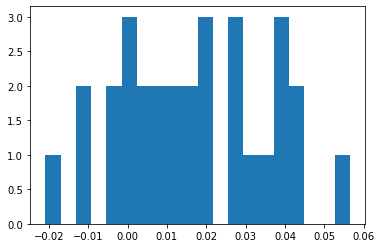

In [59]:
mean_ates = predict_results.mean(1)

print(mean_ates.mean(0), predict_results.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output : 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

['age', 'weight', 'glucose', 'gcs_score_rand', 'nihss', 'sbprand', 'dbprand', 'gender', 'antiplat_rand', 'atrialfib_rand', 'infarct', 'TACI', 'PACI', 'LACI', 'POCI']


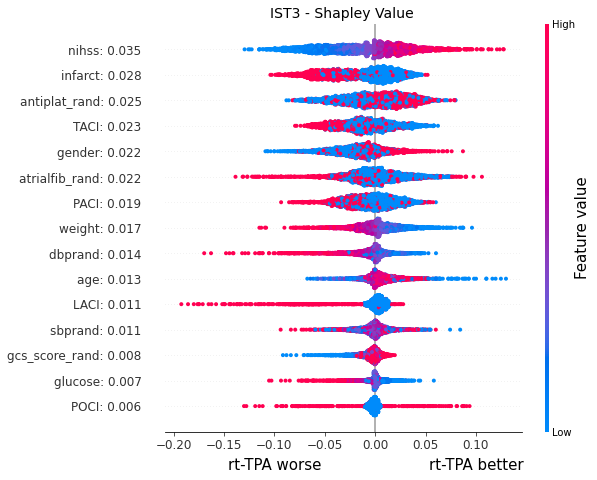

In [85]:
data = Dataset("ist3", 0)

avg_shap = pkl.load(open("results/ist3/shap_bootstrapped.pkl",'rb'))

x, y, w = data.get_data()

plot_feature_values_original(
    avg_shap.mean(0), 
    x,
    feature_name
)

print(feature_name)

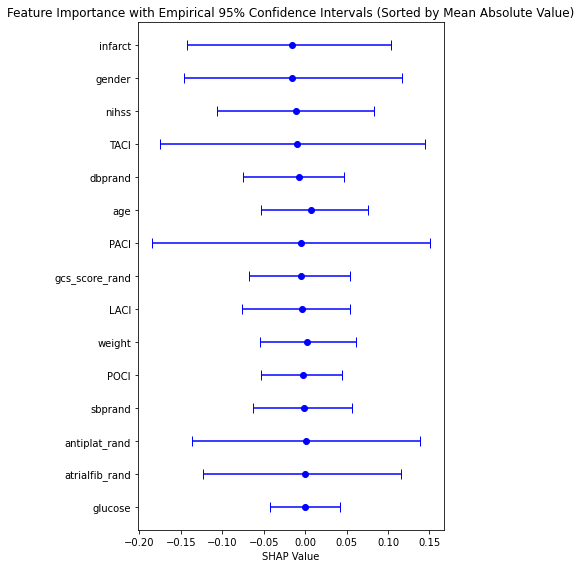

In [109]:
mean_shap = avg_shap.mean(axis=(0,1))
std_shap = avg_shap.std(axis=(0,1))

lower_bound = np.percentile(avg_shap, 5, axis=(0,1))
upper_bound = np.percentile(avg_shap, 95, axis=(0,1))


sorted_indices = np.argsort(np.abs(mean_shap))

mean_shap = mean_shap[sorted_indices]
lower_bound = lower_bound[sorted_indices]
upper_bound = upper_bound[sorted_indices]
sorted_feature_names = np.array(feature_name)[sorted_indices]

fig, ax = plt.subplots(figsize=(7, 8))
y_pos = np.arange(len(mean_shap))

ax.errorbar(
    mean_shap,
    y_pos, 
    xerr=[mean_shap - lower_bound, upper_bound - mean_shap],
    fmt='o', capsize=5, color='blue'
)

ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_feature_names)
ax.set_xlabel('SHAP Value')
ax.set_title('Feature Importance with Empirical 95% Confidence Intervals (Sorted by Mean Absolute Value)')

plt.tight_layout()
plt.show()

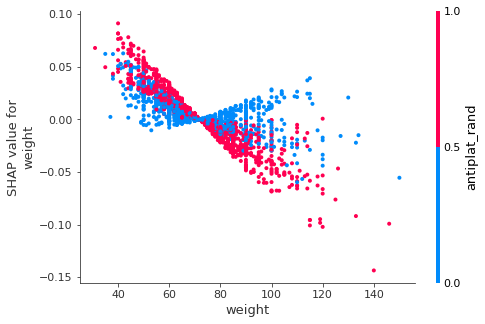

In [84]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

shap.dependence_plot(
    "rank(8)", 
     avg_shap.mean(0), 
     x_raw, 
     feature_names=feature_name,
     # interaction_index="gender"
)

<ErrorbarContainer object of 3 artists>

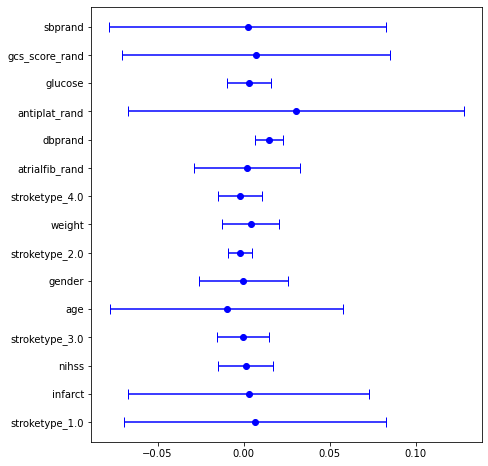

In [276]:


avg_shap.reshape(-1, avg_shap.shape[2])


global_mean_shap = avg_shap.mean(0).mean(0)
erros = np.std(avg_shap.reshape(-1, avg_shap.shape[2]), axis=1)

sorted_indices = np.argsort(np.abs(global_mean_shap))[::-1]
ordered_feature_names = [data.get_feature_names()[i] for i in sorted_indices]


fig, ax = plt.subplots(figsize=(7, 8))
y_pos = np.arange(len(global_mean_shap))

ax.errorbar(
    global_mean_shap,
    ordered_feature_names, 
    xerr=np.array(errors).T, 
    fmt='o', capsize=5, color='blue'
)

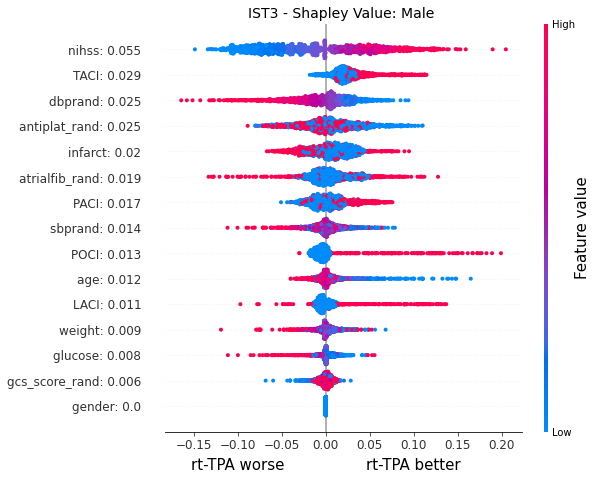

In [45]:
avg_shap = pkl.load(open("results/ist3/gender=1.0_shap.pkl",'rb'))

gender_index = data.get_feature_names().tolist().index("gender")

plot_feature_values_original(
    avg_shap.mean(0), 
    x[x[:, gender_index]== 1], 
    feature_name
)

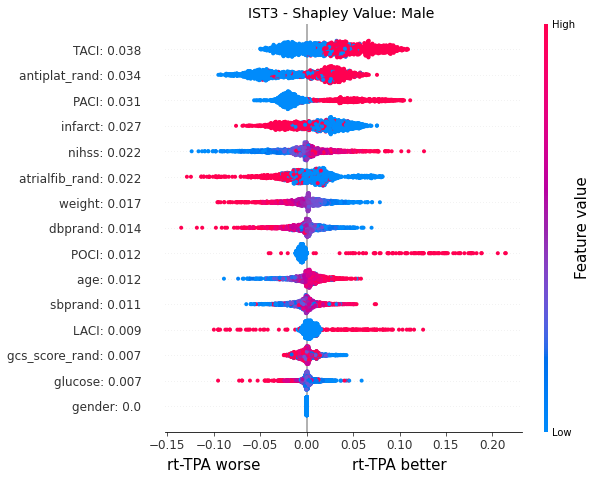

In [46]:
avg_female_shap = pkl.load(open("results/ist3/gender=0.0_shap.pkl",'rb'))

plot_feature_values_original(
    avg_female_shap.mean(0), 
    x[x[:, gender_index]== 0], 
    feature_name
)

In [131]:
baseline_output = model.predict(np.mean(x[x[:, gender_index]== 0], axis=0).reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    avg_shap.mean(0)[0].reshape(1, -1),  
    baseline_output[0],
    data=x[x[:, gender_index]== 0],
    feature_names=feature_name,
)

shap.plots.waterfall(exp[0], max_display=len(feature_name)) 

array([0., 0., 0., ..., 0., 0., 1.])

In [171]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)


In [298]:
shap.initjs()

baseline_output = np.mean(predict_results)

exp = Explanation(
    avg_shap.mean(0)[1].reshape(1, -1),  
    baseline_output,
    data=x_raw,
    feature_names=feature_name,
)

shap.plots.force(exp[0]) 

In [187]:
female_baseline_output = np.mean(predict_results.mean(0)[x[:, gender_index]==0])

exp = Explanation(
    avg_female_shap.mean(0)[1].reshape(1, -1),  
    female_baseline_output,
    data=x_raw,
    feature_names=feature_name,
)

shap.plots.force(exp[0])


In [153]:
shap.force_plot(
    baseline_output, 
    avg_shap.mean(0)[0].reshape(1, -1),
    x[x[:, gender_index]== 0][0], 
    feature_names=feature_name
    # link="logit"
)

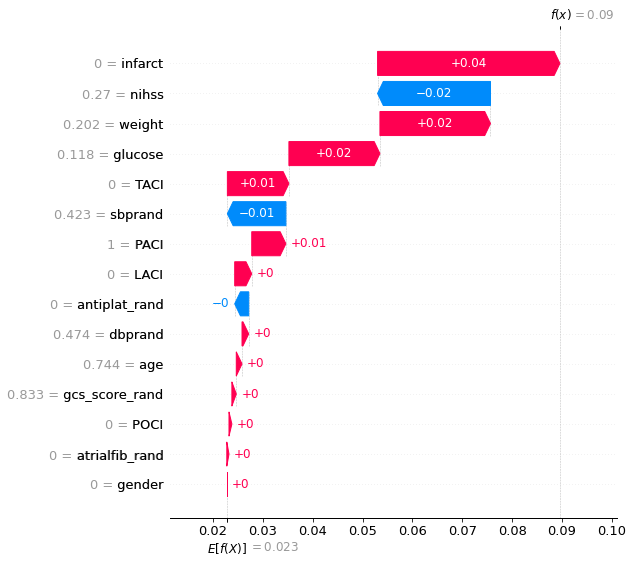

In [146]:
baseline_output = np.mean(predict_results.mean(0)[x[:, gender_index]==0])

exp = Explanation(
    avg_female_shap.mean(0)[0].reshape(1, -1),  
    baseline_output,
    data=x[x[:, gender_index]==0],
    feature_names=feature_name,
)

shap.plots.waterfall(exp[0], max_display=len(feature_name)) 

In [ ]:
baseline_output = model.predict(np.mean(x[x[:, gender_index]== 0], axis=0).reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    avg_shap.mean(0)[0].reshape(1, -1),  
    baseline_output[0],
    data=x[x[:, gender_index]== 0],
    feature_names=feature_name,
)

shap.plots.waterfall(exp[0], max_display=len(feature_name)) 

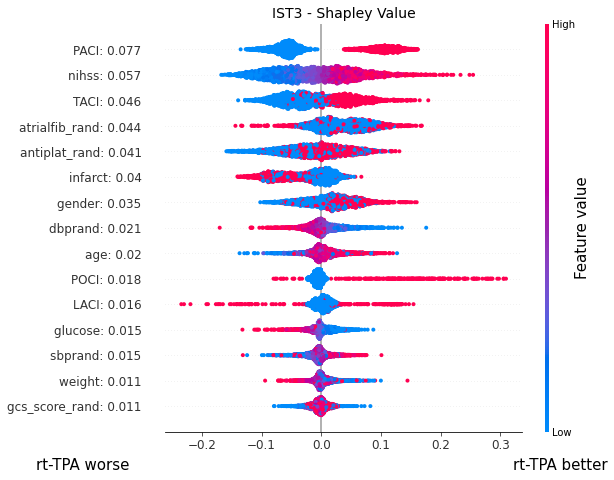

In [28]:
plot_feature_values_original(
    average_shap.mean(0), 
    x, 
    feature_name
)

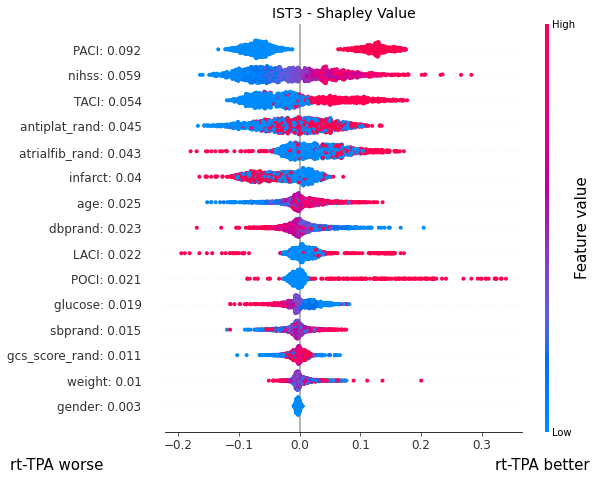

In [34]:
plot_feature_values_original(
    average_male_shap.mean(0), 
    x[x[:,gender_index]==1], 
    feature_name
)

In [31]:
average_female_shap.shape

(10, 1569, 15)

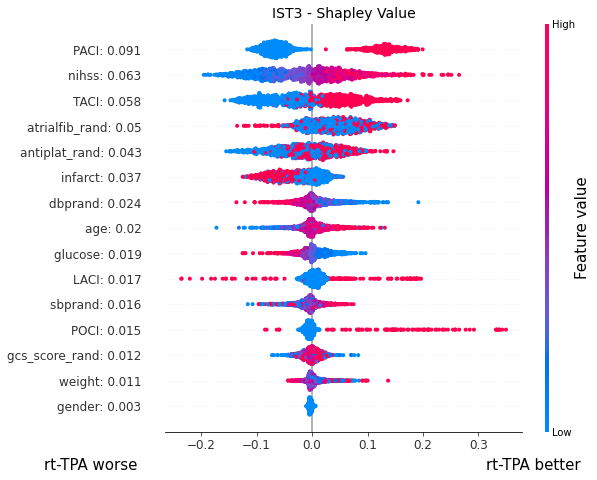

In [33]:
plot_feature_values_original(
    average_female_shap.mean(0), 
    x[x[:,gender_index]==0], 
    feature_name
)

In [15]:
mean_baseline = x.mean(0)

mean_model = ShapleyValueSampling(model)

mean_baseline_shap = mean_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                perturbations_per_eval=10,
                baselines = torch.tensor(mean_baseline.reshape(1,-1)),
                show_progress=True
).detach().cpu().numpy()

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:50<00:00, 39.39it/s]


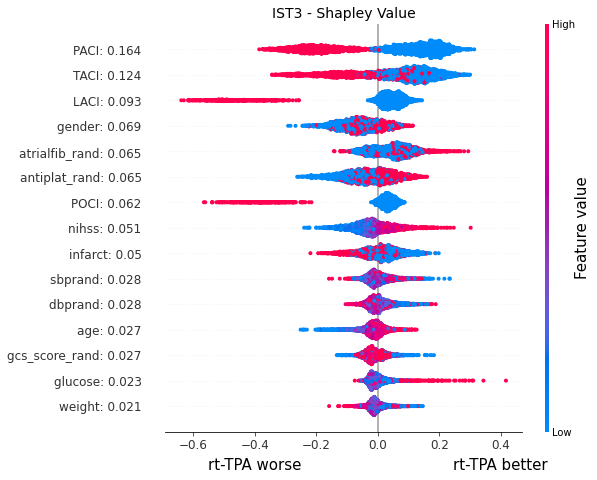

In [16]:
plot_feature_values_original(
    mean_baseline_shap, 
    x, 
    feature_name
)

In [20]:
rb_baseline = x[np.random.choice(len(x), len(x), replace=True)].mean(0)

rbshap_model = ShapleyValueSampling(model)

rbshap = rbshap_model.attribute(
                torch.tensor(x),
                n_samples=1000,
                perturbations_per_eval=10,
                baselines = torch.tensor(rb_baseline.reshape(1,-1)),
                show_progress=True
).detach().cpu().numpy()

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:47<00:00, 42.10it/s]


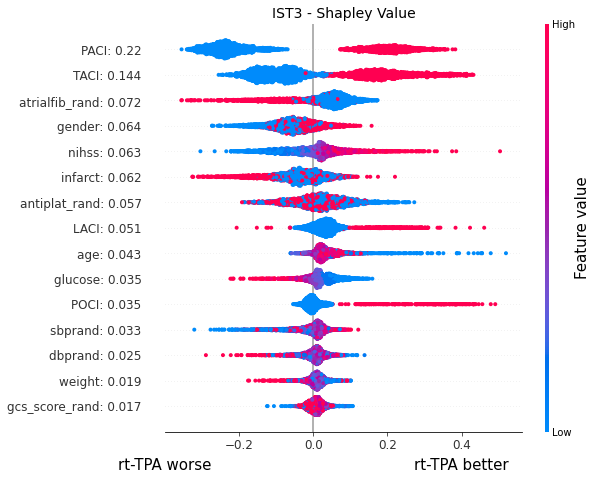

In [21]:
plot_feature_values_original(
    rbshap, 
    x, 
    feature_name
)


Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:21<00:00, 93.63it/s]


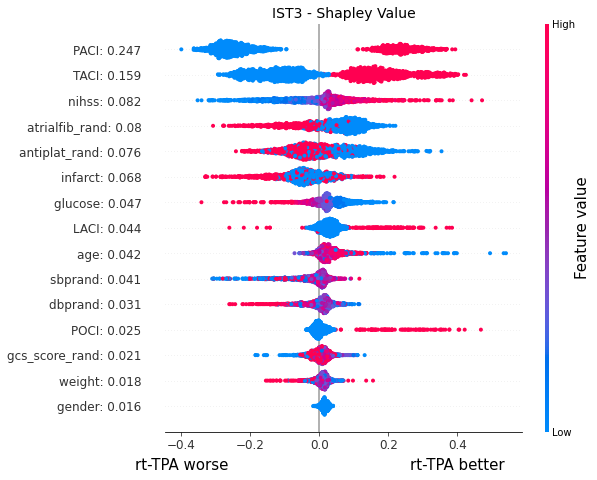

In [22]:
female_index = data.get_feature_names().tolist().index('gender')

female_sample = x[x[:,female_index] ==0]

female_baseline = female_sample.mean(0)

marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

female_shap = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(female_sample),
                n_samples=1000,
                baselines = torch.tensor(female_baseline.reshape(1,-1)),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values_original(female_shap, female_sample, feature_name)

Shapley Value Sampling attribution: 100%|███| 2001/2001 [00:21<00:00, 92.51it/s]


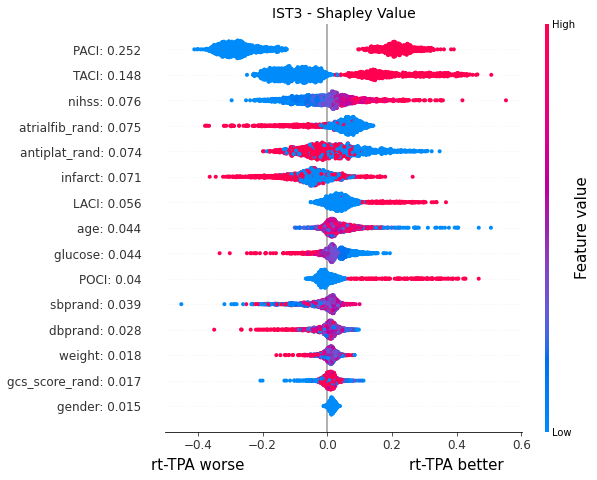

In [23]:


plot_feature_values_original(male_shap, male_sample, feature_name)

## Ppl who are younger than 80

In [24]:
plot_feature_values_original(
    baseline_shapley_value[baseline[:, 0] < age_threshold],
    baseline[baseline[:, 0] < age_threshold], 
)

NameError: name 'baseline_shapley_value' is not defined

## Ppl who are older than 80

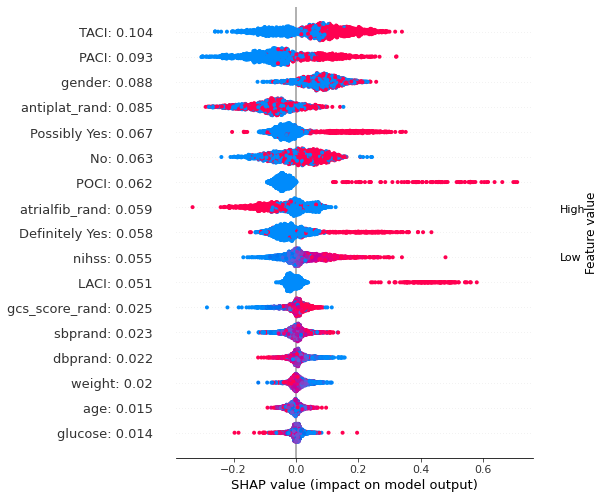

In [337]:
plot_feature_values_original(
    baseline_shapley_value[baseline[:, 0]> age_threshold],
    baseline[baseline[:, 0]> age_threshold], 
)

## Example to show individual prediction

In [27]:

baseline_output = model.predict(np.mean(baseline, axis=0).reshape(1,-1)).detach().cpu().numpy()

shap_v = {'base_values': baseline_output}

exp = Explanation(
    baseline_shapley_value[3].reshape(1, -1),  
    baseline_output[0],
    data=baseline_unnorm,
    feature_names=feature_names_v2,
)

shap.plots.waterfall(exp[0], max_display=baseline.shape[1]) 

NameError: name 'baseline' is not defined

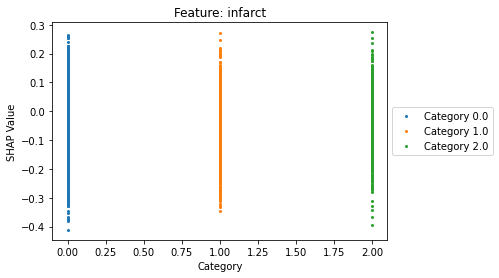

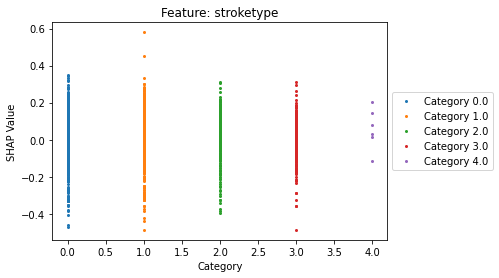

In [71]:
plot_categorical_feature_values(marginal_shapley_value, baseline, n_categories)

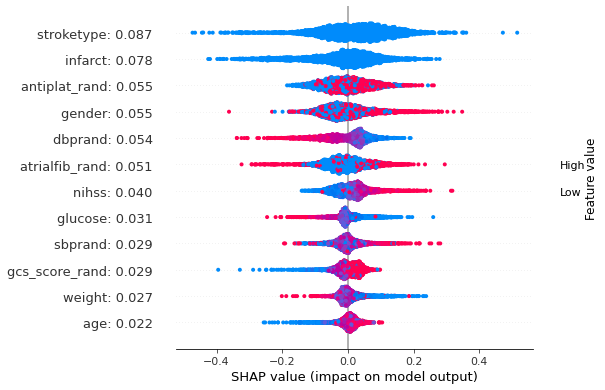

In [6]:
plot_feature_values(baseline_shapley_value, baseline, n_categories)

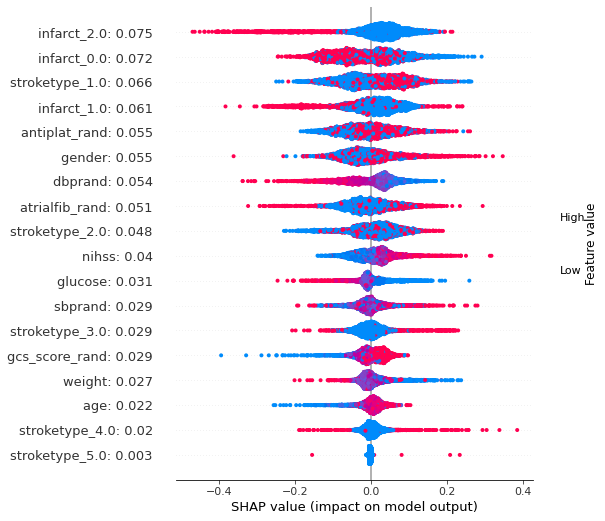

In [7]:
plot_feature_values_original(baseline_shapley_value, baseline)

Shapley Value Sampling attribution: 100%|█| 18001/18001 [01:01<00:00, 291.47it/s


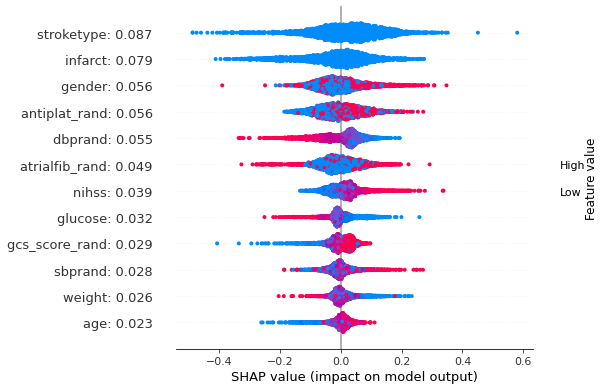

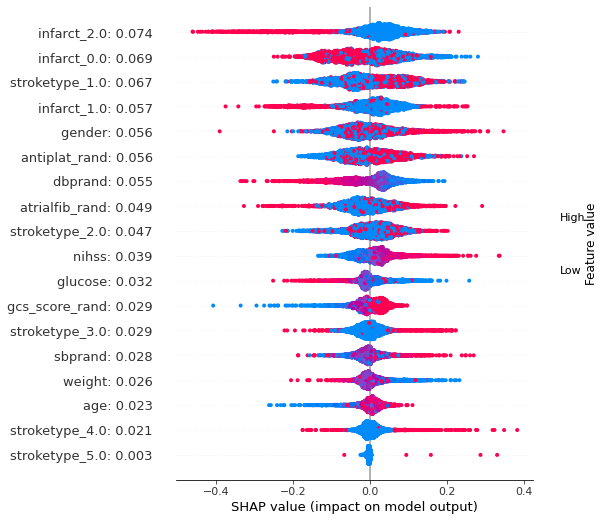

In [8]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

marginal_shapley_value_sampling_model = ShapleyValueSampling(model)

marginal_shapley_value = marginal_shapley_value_sampling_model.attribute(
                torch.tensor(baseline),
                n_samples=1000,
                baselines = torch.tensor(np.mean(baseline, axis=0).reshape(1,-1)),
                perturbations_per_eval = 10,
                show_progress=True
).detach().cpu().numpy()

plot_feature_values(marginal_shapley_value, baseline, n_categories)
plot_feature_values_original(marginal_shapley_value, baseline)

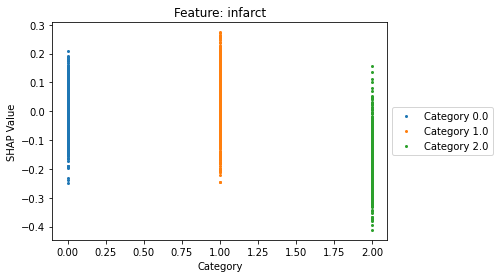

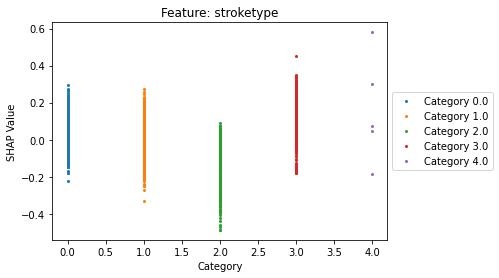

In [11]:
plot_categorical_feature_values(marginal_shapley_value, baseline, n_categories)

Permutation explainer: 3036it [01:48, 25.90it/s]                                


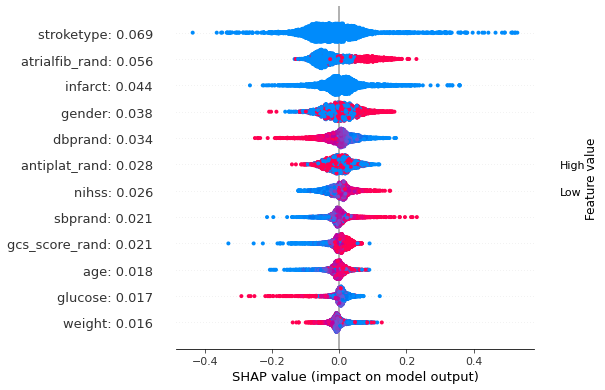

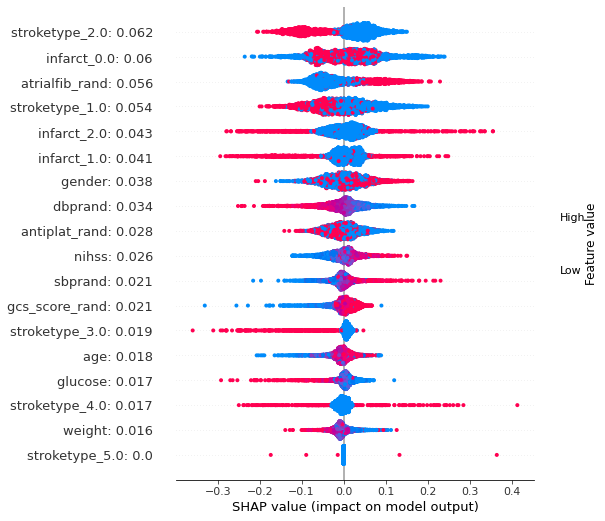

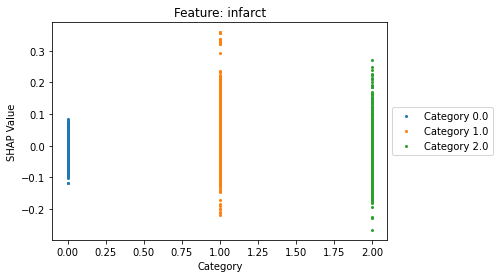

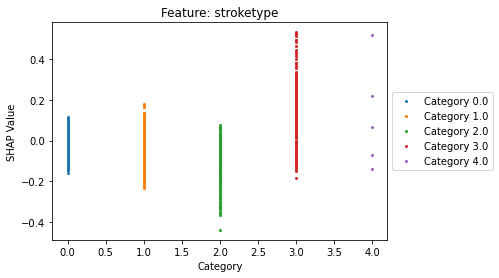

In [9]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_feature_values_original(shap_values.values, baseline)

plot_categorical_feature_values(shap_values.values, baseline, n_categories)

In [10]:
baseline = np.concatenate([x_train, x_val,x_test], axis=0)

explainer = shap.explainers.Sampling(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_feature_values_original(shap_values.values, baseline)

plot_categorical_feature_values(shap_values.values, baseline, n_categories)

  3%|█                                      | 81/3035 [01:43<1:02:52,  1.28s/it]


KeyboardInterrupt: 

[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6138721704483032, train_loss: 0.6458441019058228
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.45374795794487, train_loss: 0.48837146162986755
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.43283316493034363, train_loss: 0.44245123863220215
[po_est_impute_unconditional_mean] Epoch: 150, current validation loss: 0.42693275213241577, train_loss: 0.41558700799942017
[po_est_impute_unconditional_mean] Epoch: 200, current validation loss: 0.4265056550502777, train_loss: 0.41207605600357056
[po_est_impute_unconditional_mean] Epoch: 0, current validation loss: 0.6819400787353516, train_loss: 0.6906774640083313
[po_est_impute_unconditional_mean] Epoch: 50, current validation loss: 0.5722461342811584, train_loss: 0.5007331371307373
[po_est_impute_unconditional_mean] Epoch: 100, current validation loss: 0.5673696994781494, train_loss: 0.4491886496543884
[po_est_impute_unc

Permutation explainer: 3036it [00:49, 48.75it/s]                                


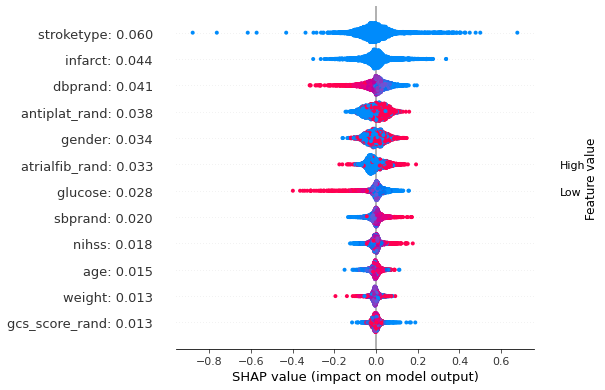

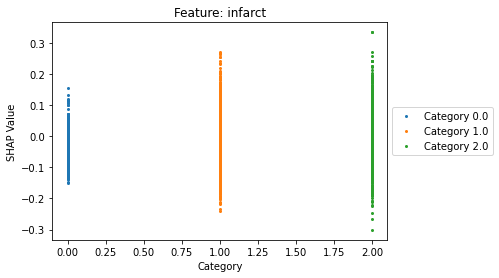

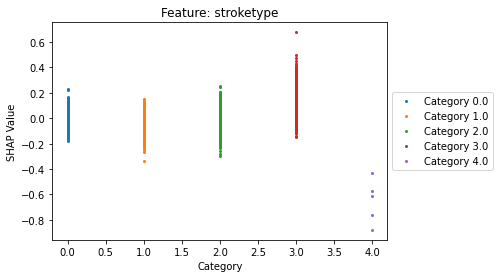

In [72]:
model = pseudo_outcome_nets.RLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

learner_explanations = {}

# learner_explanations["shapley_sampling"] = np.zeros((x_test.shape))
# marginal_extension = removal.MarginalExtension(x_test, model)

# for test_ind in range(len(x_test)):
#     instance = x_test[test_ind]
#     game = games.PredictionGame(marginal_extension, instance)
#     explanation = shapley_sampling.ShapleySampling(game, thresh=0.01, batch_size=128)
#     learner_explanations["shapley_sampling"][test_ind] = explanation.values.reshape(-1, x_test.shape[1])

# plot_feature_values(learner_explanations["shapley_sampling"])

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.9554045796394348, train_loss: 0.9926087260246277
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5899448990821838, train_loss: 0.5736987590789795
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5009039640426636, train_loss: 0.44446292519569397
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.480671226978302, train_loss: 0.38867247104644775
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.47752100229263306, train_loss: 0.3484068810939789
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6873695254325867, train_loss: 0.7140087485313416
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5291489362716675, train_loss: 0.5072386860847473
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5072816014289856, train_loss: 0.4401850402355194
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.503801047

Permutation explainer: 3036it [00:49, 48.50it/s]                                


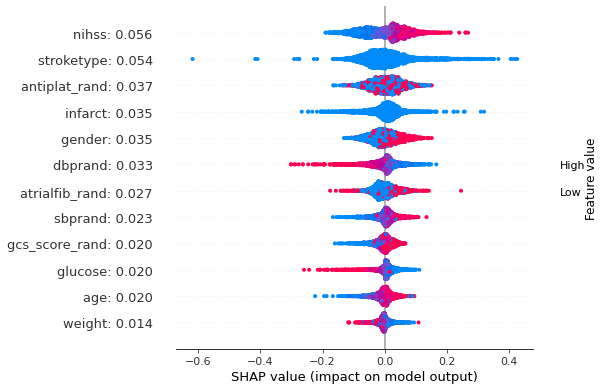

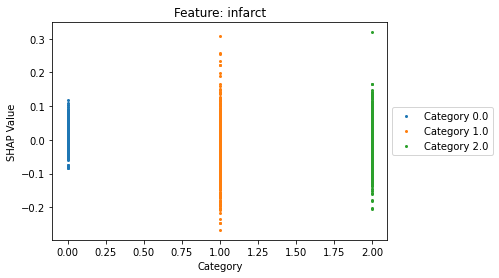

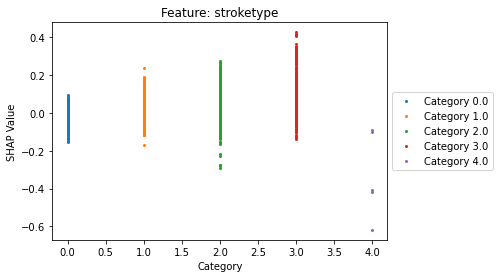

In [73]:
model = pseudo_outcome_nets.RALearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[TARNet] Epoch: 0, current validation loss: 0.6893719434738159 train_loss: 0.6900596022605896
[TARNet] Epoch: 50, current validation loss: 0.6488354206085205 train_loss: 0.64727783203125
[TARNet] Epoch: 100, current validation loss: 0.5971236228942871 train_loss: 0.588253915309906
[TARNet] Epoch: 150, current validation loss: 0.5569208264350891 train_loss: 0.5351617932319641
[TARNet] Epoch: 200, current validation loss: 0.5440869927406311 train_loss: 0.5155655145645142
[TARNet] Epoch: 250, current validation loss: 0.537254810333252 train_loss: 0.5045313835144043
[TARNet] Epoch: 300, current validation loss: 0.5317315459251404 train_loss: 0.4943632483482361
[TARNet] Epoch: 350, current validation loss: 0.5270311832427979 train_loss: 0.4881545603275299
[TARNet] Epoch: 400, current validation loss: 0.5236188173294067 train_loss: 0.4803340435028076
[TARNet] Epoch: 450, current validation loss: 0.521166205406189 train_loss: 0.47150352597236633
[TARNet] Epoch: 500, current validation loss: 0

Permutation explainer: 3036it [01:29, 29.92it/s]                                


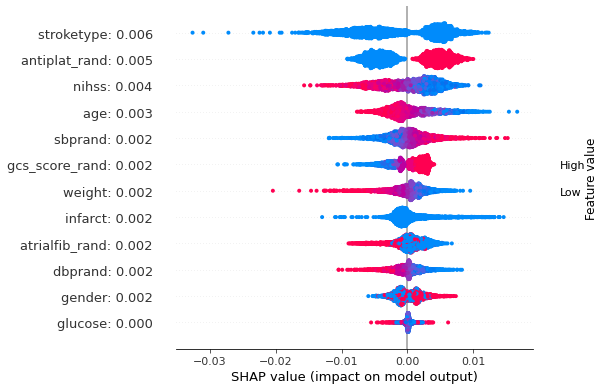

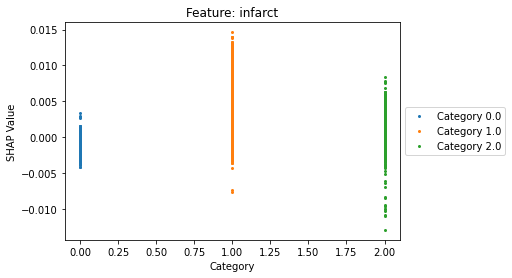

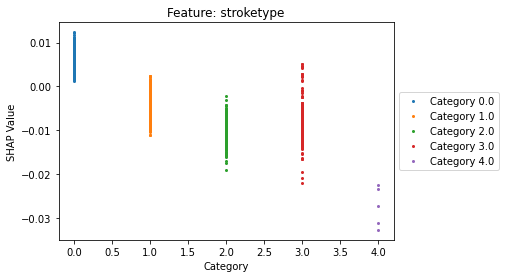

In [74]:
model = cate_models.torch.TARNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            n_layers_r=2,
            n_layers_out=2,
            n_units_out=100,
            n_units_r=100,
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            early_stopping = True,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[DragonNet] Epoch: 0, current validation loss: 1.3849462270736694 train_loss: 1.385475754737854
[DragonNet] Epoch: 50, current validation loss: 1.3019402027130127 train_loss: 1.2929776906967163
[DragonNet] Epoch: 100, current validation loss: 1.240375280380249 train_loss: 1.2152279615402222
[DragonNet] Epoch: 150, current validation loss: 1.2227540016174316 train_loss: 1.1884409189224243
[DragonNet] Epoch: 200, current validation loss: 1.2129709720611572 train_loss: 1.1677701473236084
[DragonNet] Epoch: 250, current validation loss: 1.2092010974884033 train_loss: 1.1542671918869019


Permutation explainer: 3036it [02:32, 18.57it/s]                                


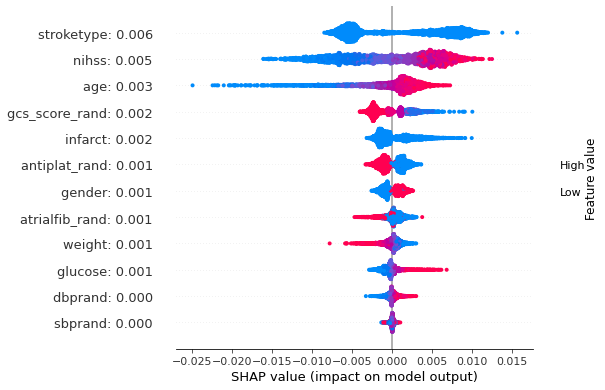

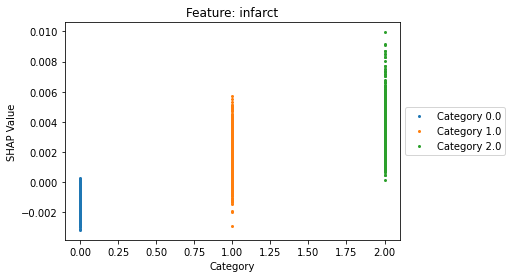

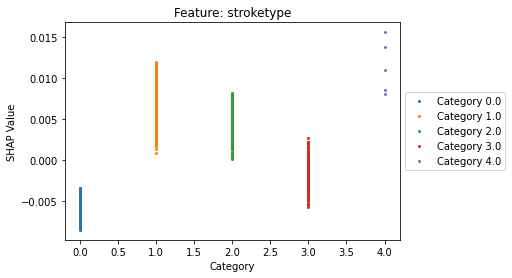

In [75]:
model = cate_models.torch.DragonNet(
            x_train.shape[1],
            binary_y=(len(np.unique(y_train)) == 2),
            batch_size=128,
            n_iter=1000,
            lr=1e-5,
            batch_norm=False,
            nonlin="relu",
        )

model.fit(x_train, y_train, w_train)

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

[slearner_po_estimator] Epoch: 0, current validation loss: 0.7561942338943481, train_loss: 0.7621263265609741
[slearner_po_estimator] Epoch: 50, current validation loss: 0.4989801347255707, train_loss: 0.48219841718673706
[slearner_po_estimator] Epoch: 100, current validation loss: 0.4801802635192871, train_loss: 0.4397190809249878
[slearner_po_estimator] Epoch: 150, current validation loss: 0.4787187874317169, train_loss: 0.4239770770072937
[slearner_po_estimator] Epoch: 200, current validation loss: 0.4785993695259094, train_loss: 0.4225805401802063


Permutation explainer: 3036it [01:28, 30.19it/s]                                


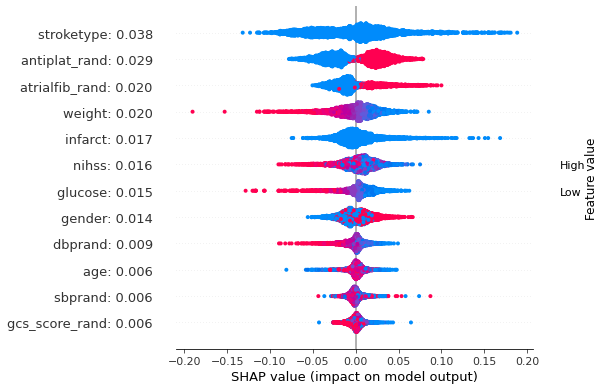

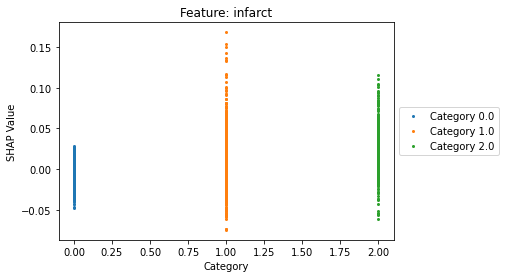

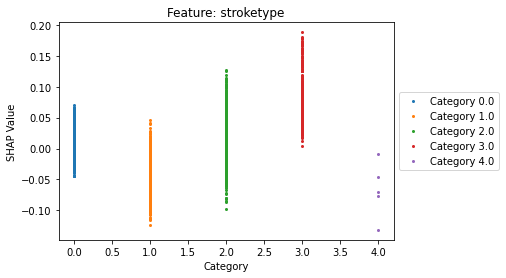

In [76]:
model = cate_models.torch.SLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)

model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, baseline)
shap_values = explainer(baseline)

plot_feature_values(shap_values.values, baseline, n_categories)
plot_categorical_feature_values(shap_values.values, baseline, n_categories)

In [ ]:
model = cate_models.torch.TLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0), n_categories)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.7552102208137512, train_loss: 0.7444889545440674
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5285875201225281, train_loss: 0.4970513582229614
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.4879630506038666, train_loss: 0.43373599648475647
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.4751794934272766, train_loss: 0.38654184341430664
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4693801999092102, train_loss: 0.3650873601436615
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6363965272903442, train_loss: 0.669018566608429
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5158784985542297, train_loss: 0.4900670349597931
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5132080912590027, train_loss: 0.4525911509990692
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.5134476423

Permutation explainer: 2550it [02:23, 16.44it/s]                                


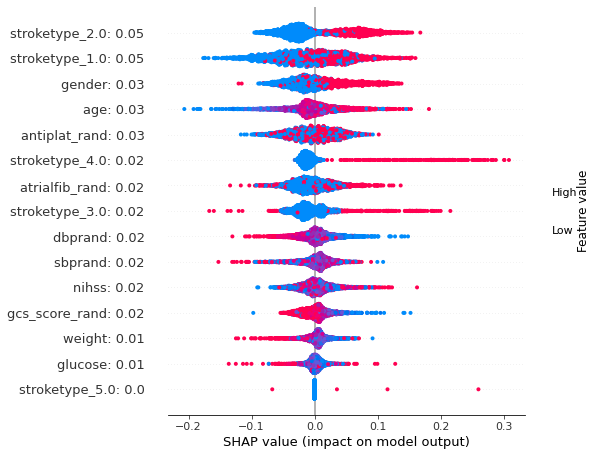

In [110]:
model = cate_models.torch.XLearner(  
        x_train.shape[1],
        binary_y=(len(np.unique(y_train)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
)


model.fit(x_train, y_train, w_train)

def model_predict(X):
    return model.predict(X).detach().cpu().numpy()

explainer = shap.explainers.Permutation(model_predict, np.concatenate([x_train, x_test], axis=0))
shap_values = explainer(np.concatenate([x_train, x_test], axis=0))
plot_feature_values(shap_values.values, np.concatenate([x_train, x_test], axis=0))

average tx effect 0.0062297457
average tx effect 0.00623464


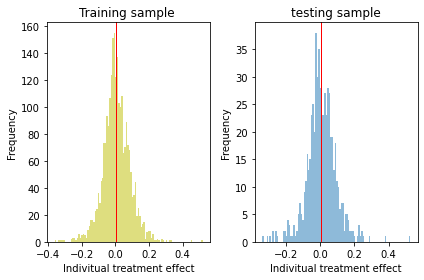

In [53]:
import matplotlib.pyplot as plt 

train_output = model(x_train).detach().cpu().numpy()
test_output = model(x_test).detach().cpu().numpy()

print("average tx effect", np.mean(train_output))
print("average tx effect", np.mean(test_output))

plt.subplot(1,2,1)
plt.hist(train_output, bins=100 ,alpha= 0.5, color="y")
plt.axvline(x= np.mean(train_output), linewidth=1, color='r')

plt.title("Training sample " )
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(test_output,bins=100 , alpha = 0.5)
plt.axvline(x= np.mean(test_output), linewidth=1, color='r')

plt.title("testing sample")
plt.xlabel("Indivitual treatment effect")
plt.ylabel("Frequency")
plt.tight_layout()

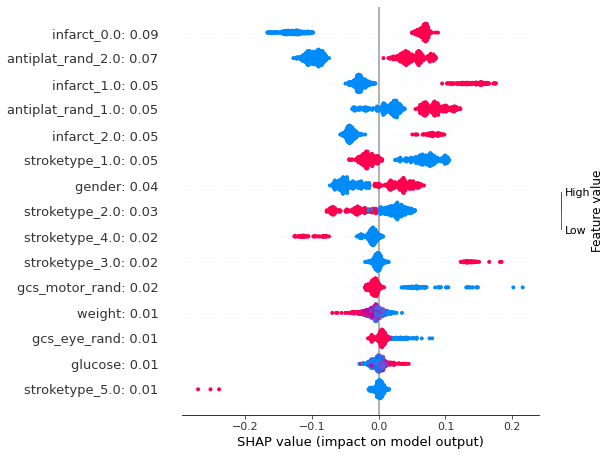

In [54]:
plot_feature_values(learner_explanations["shapley_sampling"])

In [ ]:
# Shapley value sampling
shapley_value_sampling_model = ShapleyValueSampling(model)

learner_explanations["shapley_sampling_0"] = shapley_value_sampling_model.attribute(
                                                 torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                                n_samples=500,
                                                perturbations_per_eval=10,
                                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["shapley_sampling_0"])

In [ ]:
# Shapley value sampling
ig = IntegratedGradients(model)

learner_explanations["ig"] = ig.attribute(
                                    torch.from_numpy(x_test).to("cuda:1").requires_grad_(),
                                    n_steps=500,
                            ).detach().cpu().numpy()

plot_feature_values(learner_explanations["ig"])

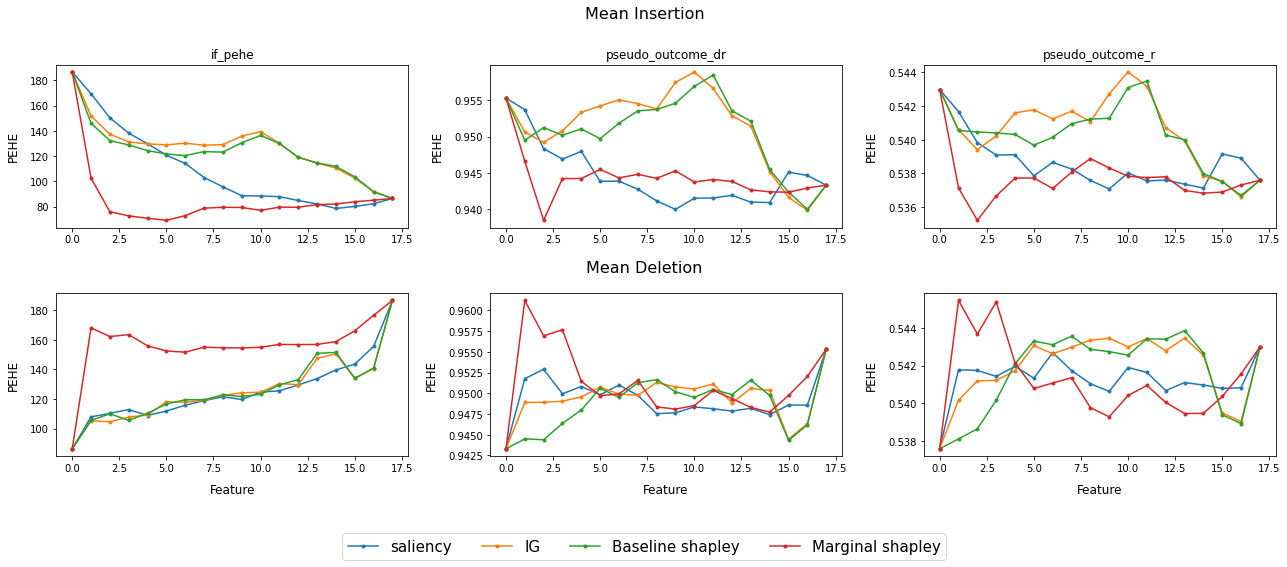

In [401]:
import pickle as pkl
import matplotlib.gridspec as gridspec


learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/ist3/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])
            auroc_ate[exp].append(results[exp_index][4])
            
            auroc_full.append(results[exp_index][7])
            auroc_full_ate.append(results[exp_index][6])
            
            auroc_random.append(results[exp_index][9])
            auroc_random_ate.append(results[exp_index][8])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


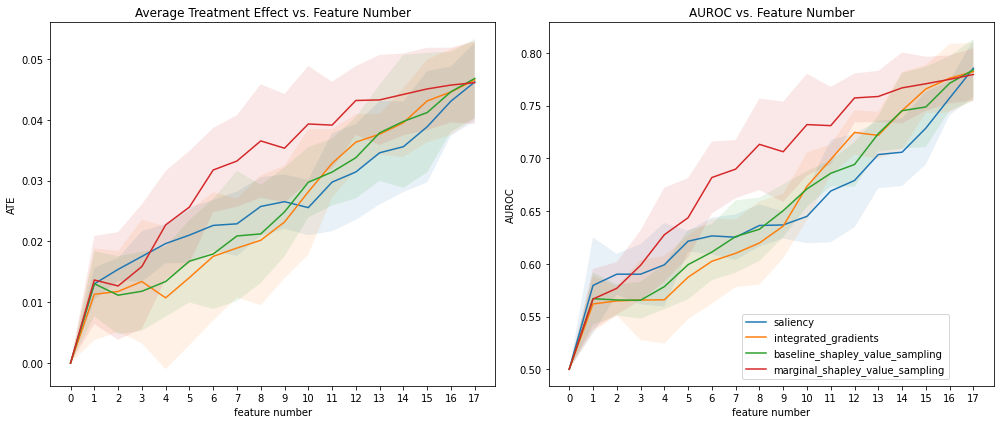

In [429]:
auroc_results  = {exp: np.array(result).mean(axis=0) for exp, result in auroc_all.items()}
auroc_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_all.items()}

ate_results = {exp:np.array(result).mean(axis=0) for exp, result in auroc_ate.items()}
ate_std  = {exp: np.array(result).std(axis=0) for exp, result in auroc_ate.items()}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 18, 1))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 18, 1))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.95, 0.1))

plt.tight_layout()
plt.show()

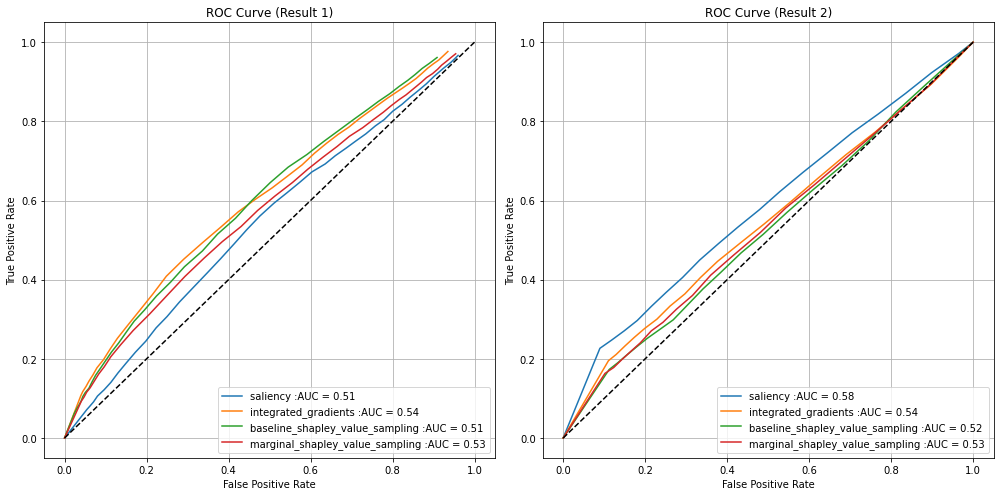

In [407]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

for i, exp in enumerate(explainers):

    data = np.mean(perturb_results_1[5 * i:5 * (i + 1)], axis=0)
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]
    ax1.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f}')
    
    data = np.mean(perturb_results_2[5 * i:5 * (i + 1)], axis=0)
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]
    ax2.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f}')

# Formatting for the first plot
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (Result 1)')
ax1.legend(loc='lower right')
ax1.grid(True)

# Formatting for the second plot
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (Result 2)')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()


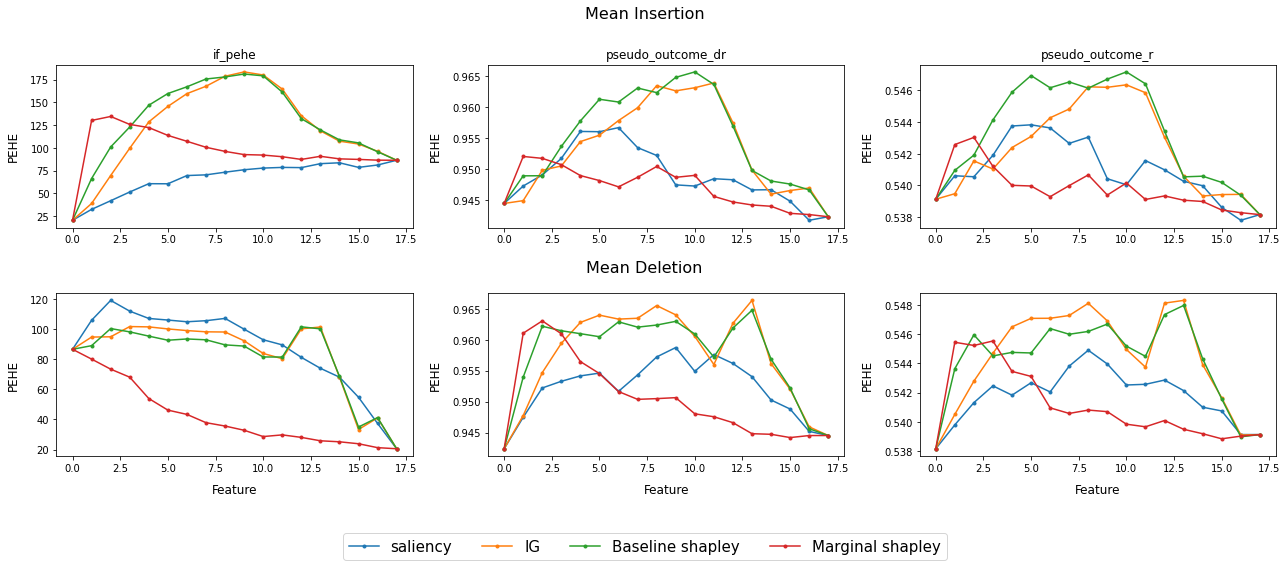

In [380]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}
auroc_ate = {exp: [] for exp in explainers}

auroc_full = []
auroc_full_ate = []
auroc_random = []
auroc_random_ate = []

perturb_results_1 = []
perturb_results_2 = []
# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:
    file_path = f"results/ist3/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
    results = pkl.load(open(file_path,'rb'))
    
    for exp_index, exp in enumerate(explainers):
        auroc_all[exp].append(results[exp_index][5])
        auroc_ate[exp].append(results[exp_index][4])

        auroc_full.append(results[exp_index][7])
        auroc_full_ate.append(results[exp_index][6])

        auroc_random.append(results[exp_index][9])
        auroc_random_ate.append(results[exp_index][8])
        
        perturb_results_1.append(results[exp_index][10])
        perturb_results_2.append(results[exp_index][11])

        for selection_type in selection_types:
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


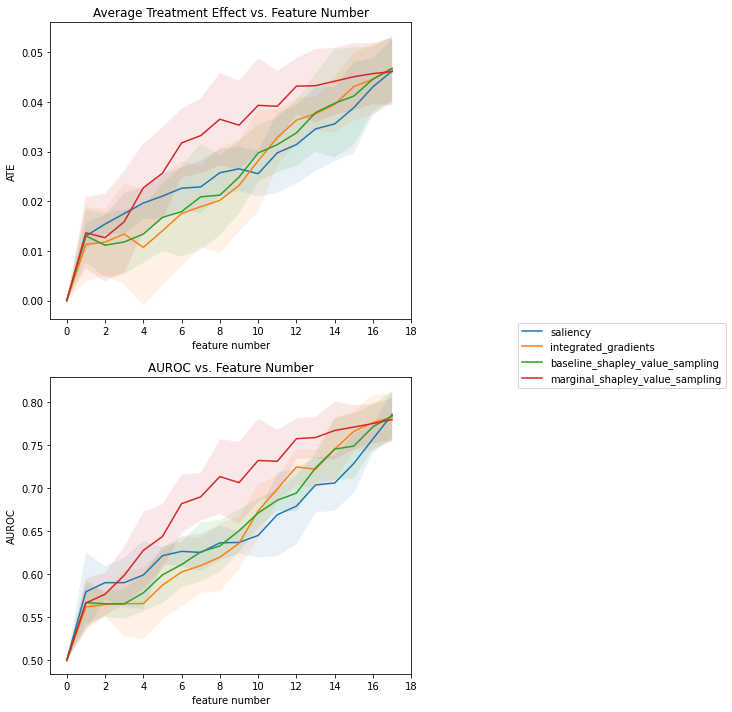

In [433]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))

# Plot ATE results
for k, v in ate_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
    ax1.fill_between(
        feature_num,
        np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
        np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
        alpha=0.1
    )

ax1.set_xticks(range(0, 19, 2))
ax1.set_xlabel("feature number")
ax1.set_ylabel("ATE")
ax1.set_title("Average Treatment Effect vs. Feature Number")

# Plot AUROC results
for k, v in auroc_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    ax2.plot(feature_num, np.insert(v, 0, 0.5), label=k)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0.5) + np.insert(auroc_std[k], 0, 0),
        np.insert(v, 0, 0.5) - np.insert(auroc_std[k], 0, 0),
        alpha=0.1
    )

ax2.set_xticks(range(0, 19, 2))
ax2.set_xlabel("feature number")
ax2.set_ylabel("AUROC")
ax2.set_title("AUROC vs. Feature Number")

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.tight_layout()
plt.show()


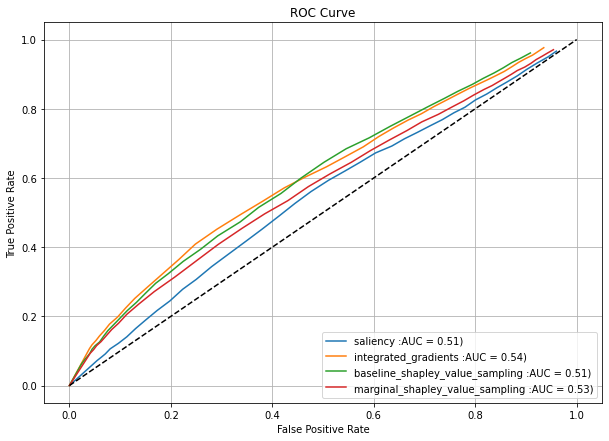

In [383]:
from sklearn.metrics import auc


plt.figure(figsize=(10, 7))

for i, exp in enumerate(explainers):
    
    data = np.mean(perturb_results_1[5*i:5*(i+1)], axis=0)

    # Calculate TPR and FPR
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])

    # Sort FPR and TPR in ascending order of FPR for plotting
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

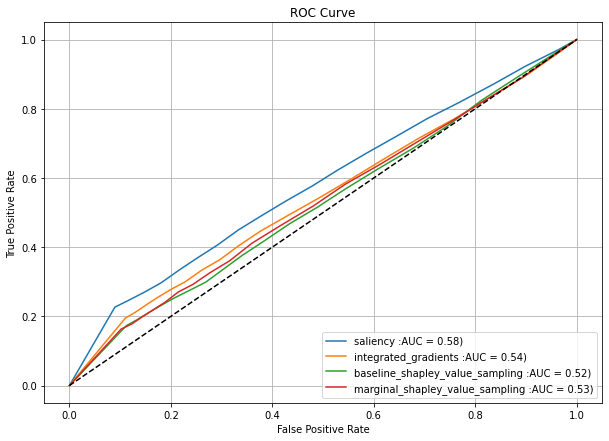

In [382]:
from sklearn.metrics import auc


plt.figure(figsize=(10, 7))

for i, exp in enumerate(explainers):
    
    data = np.mean(perturb_results_2[5*i:5*(i+1)], axis=0)

    # Calculate TPR and FPR
    tpr = data[:, 0] / (data[:, 0] + data[:, 3])
    fpr = data[:, 2] / (data[:, 2] + data[:, 1])

    # Sort FPR and TPR in ascending order of FPR for plotting
    sort_indices = np.argsort(fpr)
    fpr = fpr[sort_indices]
    tpr = tpr[sort_indices]

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{exp} :AUC = {auc(fpr, tpr):.2f})')
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [436]:
results.mean(), results.std()

(0.012009668825180814, 0.13702707239041706)

Text(0, 0.5, 'Frequency')

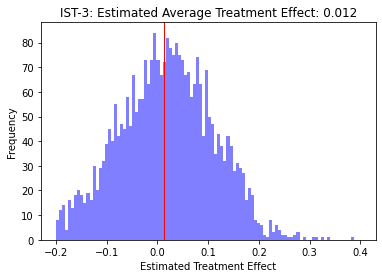

In [437]:
# plt.figure(figsize=(5, 3))

plt.hist(
    np.mean(results, axis=0), 
    bins=100, 
    range=(-0.2,0.4),
    alpha= 0.5, 
    color="b"
)
plt.axvline(x= np.mean(results), linewidth=1, color='r')

plt.title("IST-3: Estimated Average Treatment Effect: "+ str(np.round(np.mean(results) , 3)))
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")

In [430]:
data = Dataset("ist3", 0)

x, w, y = data.get_data()

trials = 10

results = np.zeros((trials, len(x)))

for i in range(trials):
    
    model = pseudo_outcome_nets.XLearner(  
        x.shape[1],
        binary_y=(len(np.unique(y)) == 2),
        n_layers_out=2,
        n_units_out=100,
        batch_size=128,
        n_iter=1000,
        nonlin="relu",
        device="cpu",
        seed= i
    )

    model.fit(x, y, w)
    results[i] = model.predict(x).detach().cpu().numpy().reshape(-1)

[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6599346399307251, train_loss: 0.6464844942092896
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5293365716934204, train_loss: 0.4748339354991913
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5049851536750793, train_loss: 0.4254840612411499
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5005167126655579, train_loss: 0.3858567476272583
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5007033944129944, train_loss: 0.3797234892845154
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.6858863830566406, train_loss: 0.7132500410079956
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.5844846963882446, train_loss: 0.5232318043708801
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.5807520747184753, train_loss: 0.4920189380645752
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.57997763156